In [1]:
%matplotlib inline
%cd "C:\Lan\web scraping using python\Project"
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import jieba
from hanziconv import HanziConv
import random
# clean non-Chinese characters
def cleantxt(raw):
	fil = re.compile(u'[^\u4e00-\u9fa5]+', re.UNICODE)
	return fil.sub('', raw)

plt.rc('font', family='Arial')
plt.rc('font', **{'sans-serif' : 'Arial','family' : 'sans-serif'})


C:\Lan\web scraping using python\Project


In [2]:
df = pd.read_csv('item_info_books.csv',index_col=0)
# separate books and ebooks
books=df.loc[(df['CateN0']=='图书'),:]
#selectbook=[(len(str(x))==13 and (str(x)).isdigit()==1) for x in books['ISBN']]
ebooks=df.loc[(df['CateN0']=='数字内容'),:]
#selectebook=[(len(str(x))==13 and (str(x)).isdigit()==1) for x in ebooks['ISBN']]
books.loc[:,'CateN1']=[cleantxt(HanziConv.toSimplified(x)) for x in books['CateN1']]
books.loc[:,'CateN2']=[cleantxt(HanziConv.toSimplified(x)) for x in books['CateN2']]
ebooks.loc[:,'CateN1']=[cleantxt(HanziConv.toSimplified(x)) for x in ebooks['CateN1']]
ebooks.loc[:,'CateN2']=[cleantxt(HanziConv.toSimplified(x)) for x in ebooks['CateN2']]
# combine level 1 and level 2 category tags
catlist=list(set(np.concatenate((ebooks['CateN1'].unique(),ebooks['CateN2'].unique(),\
                    books['CateN1'].unique(),books['CateN2'].unique()))))
catlist.sort()

# combine category labels
catcomb1= books[['CateN1','CateN2']].apply(lambda x: ''.join(x), axis=1)
catcomb2= ebooks[['CateN1','CateN2']].apply(lambda x: ''.join(x), axis=1)
# cut labels for each book
catsplit1=[jieba.lcut(x,cut_all=False, HMM=True) for x in catcomb1]
catsplit2=[jieba.lcut(x,cut_all=False, HMM=True) for x in catcomb2]
catlist=catsplit1+catsplit2

C:\Users\prettymaths\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,6,7,31,32,33,34,44,47,52,54,55,56,57,58,59,60,61,62,63,65,69,70,71,72,73,74,75,77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\prettymaths\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
C:\Users\prettymaths\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
Building prefix dict from the default dictionary ...
Loading model fr

In [3]:
# count word frequency and sort category labels
import collections
seg_list=[item for sublist in catlist for item in sublist]
wordcount=collections.Counter(seg_list)
keys=sorted(wordcount.items(), key=lambda item: item[1],reverse=True)
keylist=[x[1] for x in keys]
keylistName=[x[0] for x in keys]

In [4]:
#%% train word2Vec model based on category labels
import gensim
model = gensim.models.Word2Vec(catlist, size=100, window=5, min_count=1, alpha=0.01, workers=2,sg=0)
#similary_words = model.most_similar(w, topn=10)
model.save('category_wv_v1.model')
#model = gensim.models.Word2Vec.load('category_wv_v1.model')
# build similarity matrix
simmat=np.zeros([len(keylistName),len(keylistName)])
for i in range(len(keylistName)):
    for j in range(i,len(keylistName)):
        try:
            simmat[i][j]=model.wv.similarity(keylistName[i], keylistName[j])
            simmat[j][i]=simmat[i][j]
        except:
            simmat[i][j]=0
            simmat[j][i]=0

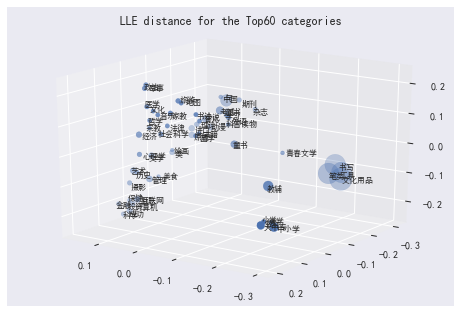

In [5]:
#%% group similar words based on similarity
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
m = manifold.LocallyLinearEmbedding(n_neighbors=20, n_components=3, method='modified', eigen_solver='dense')
#m=manifold.Isomap(n_neighbors=20, n_components=3)
out = m.fit_transform(1-simmat[0:60,0:60])    
sizedot=(np.array(keylist)+min(np.array(keylist)))/(max(np.array(keylist))+min(np.array(keylist)))*500
plt.rc('font', family='arial')
f=plt.figure()
plt.rc('font', **{'sans-serif' : 'arial','family' : 'sans-serif'})
plt.rcParams['axes.unicode_minus'] = False
ax = plt.axes(projection='3d')
ax.scatter3D(out[:, 0], out[:, 1], out[:, 2], s=sizedot)
ax.view_init(azim=125, elev=20)
plt.title("LLE distance for the Top60 categories")
plt.rc('font', family='simhei')
plt.rc('font', **{'sans-serif' : 'simhei','family' : 'sans-serif'})
for i, txt in enumerate(keylistName[0:60]):
    jitter0=(random.random()-0.5)*0.02
    jitter1=(random.random()-0.5)*0.005
    jitter2=(random.random()-1)*0.02
    ax.text(out[i, 0]+jitter0, out[i, 1]+jitter1, out[i, 2]+jitter2, txt,size=8)
plt.show()
f.savefig("Fig-1.pdf", bbox_inches='tight')

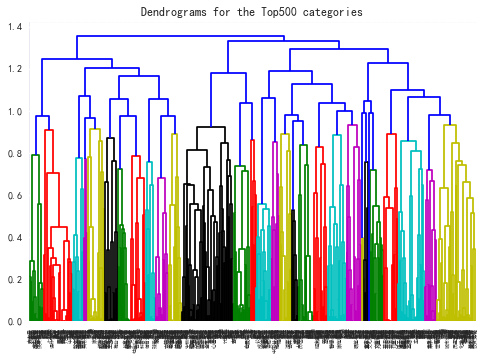

In [18]:
#%% classify each catogory tag based on distance
from scipy.cluster.hierarchy import dendrogram, linkage
dismat=(1-simmat)[0:500,0:500]
dists = dismat[np.triu_indices(500,1)]
linkage_matrix = linkage(dists, "complete")
f=plt.figure()
dendrogram(linkage_matrix, labels=keylistName[0:500])
plt.title("Dendrograms for the Top500 categories")
#f.savefig("Fig2.pdf", bbox_inches='tight')

In [19]:
import scipy
newcat=scipy.cluster.hierarchy.cut_tree(linkage_matrix, n_clusters=40).tolist()
catdict=dict(zip(keylistName, newcat))
keylist=list(catdict.keys())
for itag in keylist:
    if len(itag)<2:
        del catdict[itag]
        
# reassign each book into one of the 20 categories
# for each book, run through selected labels, pick the first matched one
newcat1=np.empty([catcomb1.shape[0],1]).tolist()
for i,ibook in enumerate(catcomb1):
    for ilabel in catdict.keys():
        if ilabel in ibook:
            newcat1[i]=ilabel
            break
books.loc[:,'New_Cat']=newcat1

newcat2=np.empty([catcomb2.shape[0],1]).tolist()
for i,ibook in enumerate(catcomb2):
    for ilabel in catdict.keys():
        if ilabel in ibook:
            newcat2[i]=ilabel
            break
ebooks.loc[:,'New_Cat']=newcat2

books.to_csv('Recategorized_books.csv',encoding='utf-8-sig')
ebooks.to_csv('Recategorized_ebooks.csv',encoding='utf-8-sig')


In [61]:
# To produce Fig2 read in the book information withe cleaned categories
books = pd.read_csv('Recategorized_books.csv',index_col=0)
ebooks = pd.read_csv('Recategorized_ebooks.csv',index_col=0)
books.loc[:,'ISBN']=[str(x)[0:13] for x in books['ISBN']]
ebooks.loc[:,'ISBN']=[str(x)[0:13] for x in ebooks['ISBN']]

# select only books and ibooks with ISBN
selectbook=[(len(x)==13 and x.isdigit()==1) for x in books['ISBN']]
books_select=books.loc[selectbook,['CateN1','CateN2','New_Cat','ISBN']]
selectebook=[(len(x)==13 and x.isdigit()==1) for x in ebooks['ISBN']]
ebooks_select=ebooks.loc[selectebook,['CateN1','CateN2','New_Cat','ISBN']]

# join isbn
df_db= pd.read_csv('book_db.csv',index_col=0)
df_db=df_db.loc[df_db['Error']!=1,:]
df_db.rename(columns={'isbn13':'ISBN'},inplace=True)
df_db.loc[:,'ISBN']=[str(x)[0:13] for x in df_db['ISBN']]

commonbooks=pd.merge(books_select,df_db[['avgrating','numRaters','pubdate','ISBN']],\
                  on='ISBN',how='inner')
commonebooks=pd.merge(ebooks_select,df_db[['avgrating','numRaters','pubdate','ISBN']],\
                  on='ISBN',how='inner')

commonbooks.to_csv('commonbooks.csv',encoding='utf-8-sig')
commonebooks.to_csv('commonebooks.csv',encoding='utf-8-sig')


C:\Users\prettymaths\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (2,6,7,31,32,33,34,44,47,61,65,69,70,71,72,73,74,75,77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [62]:
#%% pick a few representative categories
commonbooks['ebook']='Paper'
commonebooks['ebook']='Electronic'
allbooks=pd.concat([commonbooks,commonebooks]).reset_index()
allbooks['pubyear']=0
for i,x in enumerate(allbooks['pubdate']):
    try: 
        allbooks.loc[i,'pubyear']=int(x[0:4])
    except:
        allbooks.loc[i,'pubyear']=np.nan

allbooks['avgrating']=[np.nan if x==0 else x for x in allbooks['avgrating']]
allbooks['numRaters']=[float(x) if x!=0 else np.nan for x in allbooks['numRaters']]
allbooks.dropna(how='any')
allbooks['pubyearcat']=pd.cut(allbooks['pubyear'],[1990,1995,2000,2005,2010,2015,2020],\
        labels=['1995','2000','2005','2010','2015','2020'])

allbooks_nonrep=allbooks.drop_duplicates('ISBN')

C:\Users\prettymaths\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


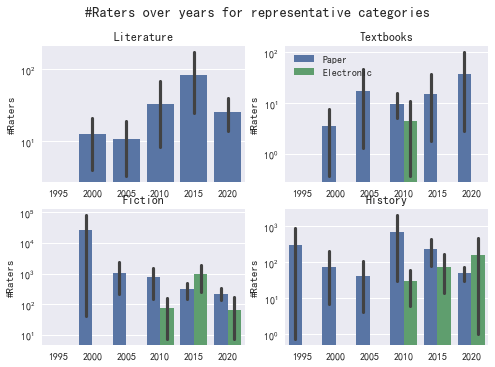

In [63]:
#%% Plot Fig-2
f=plt.figure()
f.suptitle('#Raters over years for representative categories')

plt.subplot(2, 2, 1)
allbooks_sub=allbooks_nonrep.loc[allbooks['New_Cat']=='文化',:]
ax=sns.barplot(x="pubyearcat", y="numRaters", hue="ebook", data=allbooks_sub)
plt.title('Literature')
ax.legend_.remove()
plt.xlabel('')
plt.ylabel('#Raters')
ax.set_yscale('log')


plt.subplot(2, 2, 2)
allbooks_sub=allbooks_nonrep.loc[allbooks['New_Cat']=='教辅',:]
ax=sns.barplot(x="pubyearcat", y="numRaters", hue="ebook", data=allbooks_sub)
plt.legend(loc='upper left')
plt.title('Textbooks')
plt.xlabel('')
plt.ylabel('#Raters')
ax.set_yscale('log')

plt.subplot(2, 2, 3)
allbooks_sub=allbooks_nonrep.loc[allbooks['New_Cat']=='小说',:]
ax=sns.barplot(x="pubyearcat", y="numRaters", hue="ebook", data=allbooks_sub)
ax.legend_.remove()
plt.title('Fiction')
plt.xlabel('')
plt.ylabel('#Raters')
ax.set_yscale('log')

plt.subplot(2, 2, 4)
allbooks_sub=allbooks_nonrep.loc[allbooks['New_Cat']=='历史',:]
ax=sns.barplot(x="pubyearcat", y="numRaters", hue="ebook", data=allbooks_sub)
ax.legend_.remove()
plt.title('History')
plt.xlabel('')
plt.ylabel('#Raters')
ax.set_yscale('log')

f.savefig("Fig-2.pdf")